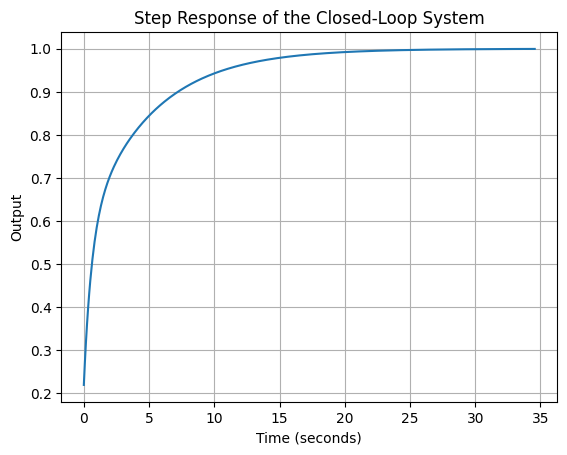

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctl

K = 1.0  
T = 1.0 

Td = 0.2
ωc = 1.0  

a1 = 1 + T**2 * ωc**2 + 2 * T * Td * ωc**2
a2 = ωc**2 * (T - Td) * (T * Td * ωc**2 - 1)

# Solve for Ti using equation (44)
Ti_possibilities = (-a1 + np.sqrt(a1**2 + 4 * a2 * T)) / (2 * a2), \
                   (-a1 - np.sqrt(a1**2 + 4 * a2 * T)) / (2 * a2)

# Choose the positive Ti as it represents a time constant
Ti = np.max(Ti_possibilities)

# Solve for Kp using equation (43) and the positive Ti
Kp = Ti * ωc * np.sqrt(1 + T**2 * ωc**2) / (K * np.sqrt((1 - Ti * Td * ωc**2)**2 + Ti**2 * ωc**2))

def validate_parameters(Kp, Ti, K, T, Td):
    try:
        # Inequality (17a)
        if not (0 < Td <= T) or Kp <= 0 or Ti <= 0:
            raise ValueError("Inequality (17a) not satisfied.")

        # Inequality (17b)
        if not (Ti >= 2 * K * Kp * T / (1 + 2 * Kp)):
            raise ValueError("Inequality (17b) not satisfied.")

        # Inequality (17c)
        if not (Ti >= 2 * T * Td * (T + K * Kp * Td) / ((T - Td) * (T + Td + 2 * K * Kp * Td))):
            raise ValueError("Inequality (17c) not satisfied.")
    except ValueError as e:
        print(e)
        return False
    
    return True

if validate_parameters(Kp,Ti,K,T,Td):
    numG = [K]
    denG = [T, 1]
    plant = ctl.tf(numG, denG)

    # PID Controller C(s) = Kp * (1 + 1/(Ti*s) + Td*s)
    numC = [Kp*Td, Kp, Kp/Ti]
    denC = [1, 0]
    controller = ctl.tf(numC, denC)

    # Closed-loop system from the feedback of plant and controller
    closed_loop = ctl.feedback(controller*plant)


    # Step response of the closed-loop system
    time, response = ctl.step_response(closed_loop)
    plt.figure()
    plt.plot(time, response)
    plt.title('Step Response of the Closed-Loop System')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Output')
    plt.grid(True)
    plt.show()


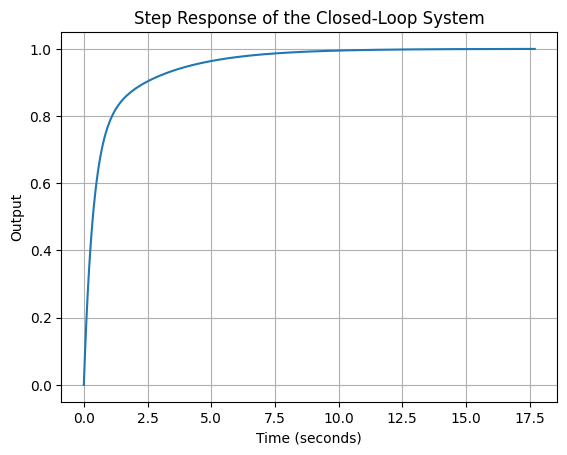

In [14]:
import numpy as np
import control as ctl
import matplotlib.pyplot as plt

K = 1.0  
T = 1.0  
ωc = 2
Td = 2 

# Calculate Kp using the given formula (equation 46)
Kp = ωc * np.sqrt(1 + T**2 * ωc**2) / (K * np.sqrt(1 + Td**2 * ωc**2))


# Define the transfer function for the plant (G(s) = K / s(1 + Ts))
numG = [K]
denG = [T, 1, 0]
plant = ctl.tf(numG, denG)

# Define the transfer function for the PD controller (C(s) = Kp(1 + Tds))
numC = [Kp*Td, Kp]
denC = [1]
controller = ctl.tf(numC, denC)

# The closed-loop transfer function from the feedback of plant and controller
closed_loop = ctl.feedback(controller*plant)


# Adjust Td based on inequality (25) and check if the PD controller parameters satisfy the condition (26)
if Td >= (2*K*Kp*T - 1)/(2*K*Kp):
    # Simulate step response
    time, response = ctl.step_response(closed_loop)

    # Plotting
    plt.figure()
    plt.plot(time, response)
    plt.title('Step Response of the Closed-Loop System')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Output')
    plt.grid(True)
    plt.show()
else:
    print("The chosen Td does not satisfy the condition Td >= (2*K*Kp*T - 1)/(2*Kp).")


/tmp/ipykernel_4102491/4052198774.py:20: RuntimeWarning: invalid value encountered in sqrt
  if Td >= (A * K * Kp / (B**2 + 2 * B * K * Kp)) + (np.sqrt(A**2 * K**2 * Kp**2 + B * (B + 2 * K * Kp) * (A**2 - 2 * B - 2 * K * Kp)) / (B**2 + 2 * B * K * Kp)):


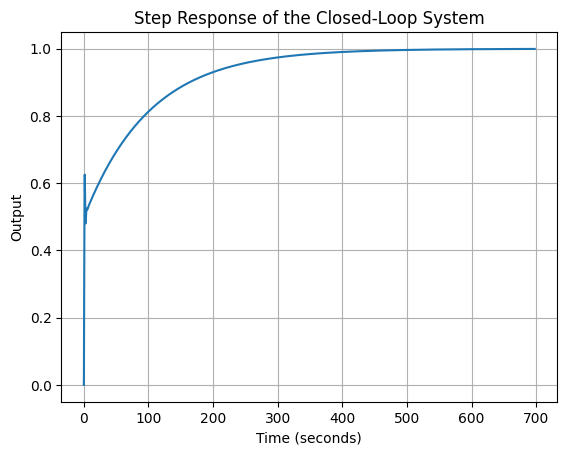

[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9]


In [29]:
import numpy as np
import control as ctl
import matplotlib.pyplot as plt
import random

def validate_pid_parameters(K, A, B, Kp, Ti, Td, ωc):
    try:
        if Kp is None or Ti is None:
            return False  # Skip validation if parameters are None

        # Inequalities 40a
        if Kp <= 0 or Ti <= 0 or Td <= 0:
            raise ValueError("Inequality 40a not satisfied: Kp, Ti, and Td must be positive.")

        if Kp <= (A**2-2*B)/(2*K):
            raise ValueError("Inequality 40b not satisfied")

                  
        # Inequality 40c
        if Td >= (A * K * Kp / (B**2 + 2 * B * K * Kp)) + (np.sqrt(A**2 * K**2 * Kp**2 + B * (B + 2 * K * Kp) * (A**2 - 2 * B - 2 * K * Kp)) / (B**2 + 2 * B * K * Kp)):
            raise ValueError("Inequality 40c not satisfied for Td.")

        # Inequality 40d
        if Ti <= (K * Kp / ((A + K * Kp * Td) * (B + K * Kp))):
            raise ValueError("Inequality 40d not satisfied for Ti.")

        # Inequality 40e
        if Ti <= (2 * A * K * Kp / (B**2 + 2 * B * K * Kp)):
            raise ValueError("Inequality 40e not satisfied for Ti.")

        # Inequality 40f
        if Ti <= 2 * Td:
            raise ValueError("Inequality 40f not satisfied for Ti.")

        # Inequality 40g
        Ti_min_40g = 2 * Td * (A**2 + A * K * Kp * Td - 2 * B - 2 * K * Kp) / (A**2 + 2 * K * Kp * Td * (A - B * Td) - 2 * B - 2 * K * Kp - B**2 * Td**2)
        if Ti <= Ti_min_40g:
            raise ValueError("Inequality 40g not satisfied for Ti.")
            
    except ValueError as error:
        # print(error)
        return False
    
    return True

K = 1
A = 2
B = 3
Td = 0.5


wc_start = 0.1
wc_end = 5
wc_step = 0.1

def calculate_Kp_Ti(ωc, K, A, B, Td):
    b0 = A * (B + ωc**2) / ((B - ωc**2)**2 + A**2 * ωc**2)
    b1 = -1 * (1 + 2 * b0 * Td * ωc**2)
    b2 = ωc**2 * (b0 * (1 + Td * ωc**2) - Td)

    discriminant = b1**2 - 4*b0*b2
    if discriminant < 0:
        # print(f"Warning: Discriminant is negative ({discriminant}) for ωc = {ωc}. No real Ti possible.")
        return None, None

    if b2 == 0:
        # print(f"Warning: Denominator is zero for ωc = {ωc}. Cannot compute Ti.")
        return None, None

    # If we reach this point, we can safely compute Ti_candidates
    Ti_candidates = (-b1 + np.array([1, -1]) * np.sqrt(discriminant)) / (2*b2)
    Ti = Ti_candidates.max()

    # Compute Kp using the positive value of Ti
    if Ti > 0:
        Kp = Ti * ωc * np.sqrt((B - ωc**2)**2 + A**2 * ωc**2) / (K * np.sqrt((1 - Ti * Td * ωc**2)**2 + Ti**2 * ωc**2))
    else:
        # print(f"Warning: Invalid Ti ({Ti}) for ωc = {ωc}.")
        return None, None

    return Kp, Ti

selected_wc = None
valid_wc = []

for wc in np.arange(wc_start, wc_end + wc_step, wc_step):
    Kp, Ti = calculate_Kp_Ti(wc, K, A, B, Td)
    # print(f"ωc = {wc}, Kp = {Kp}, Ti = {Ti}")
    # print(validate_pid_parameters(K, A, B, Kp, Ti, Td, wc))
    if Kp is not None and Ti is not None:  
        if validate_pid_parameters(K, A, B, Kp, Ti, Td, wc)==True:
            valid_wc.append(wc)

# print("Valid ωc values:", valid_wc)

if valid_wc:
    selected_wc = random.choice(valid_wc)
    # selected_wc=valid_wc[1]
    selected_Kp, selected_Ti = calculate_Kp_Ti(selected_wc, K, A, B, Td)
    # print("Selected ωc:", selected_wc)
    # print("Selected Kp:", selected_Kp)
    # print("Selected Ti:", selected_Ti)
    
    plant = ctl.tf([K], [1, A, B])
    controller = ctl.tf([selected_Kp * selected_Ti, selected_Kp], [selected_Ti, 0])
    
    system = ctl.feedback(controller * plant)
    
    time, response = ctl.step_response(system)
    
    # Plotting
    plt.figure()
    plt.plot(time, response)
    plt.title('Step Response of the Closed-Loop System')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Output')
    plt.grid(True)
    plt.show()


print(valid_wc)






